# Movie recommendation system
Recommender systems are one of the most successful and widespread application of machine learning technologies in business.
You can find large scale recommender systems in retail, video on demand, or music streaming.
- ***Examples of recommendation systems are:***
    1. Offering news articles to on-line newspaper readers, based on a prediction
of reader interests.
    2. Offering customers of an on-line retailer suggestions about what they
might like to buy, based on their past history of purchases and/or product
searches.
    3. Recommending movies to user based on there previous watch 

![](https://md.ekstrandom.net/talks/2014/txstate-recsys-research/movielens.png)

# Index
- Exploratory Data Analysis(EDA)
- Content based filtering
- Collaborative Filtering
    - Memory based collaborative filtering
        - User-Item Filtering
        - Item-Item Filtering
    - Model based collaborative filtering
        - Single Value Decomposition(SVD)
        - SVD++
- Evaluating Collaborative Filtering using SVD
- Hybrid Model

## Load Libraries 

In [3]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Dataset : Movielens
https://grouplens.org/datasets/movielens/1m

In [4]:

# Reading ratings file
path_ratings = (r'https://raw.githubusercontent.com/JohnTan38/Recommender/main/dat/')
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table(path_ratings + 'ratings.dat', sep='::', engine='python', names=rnames, header=None) #usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading movies file
path_dir = (r'https://raw.githubusercontent.com/JohnTan38/Recommender/main/')
movies = pd.read_csv(path_dir + 'movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

# Reading users file
users = pd.read_csv(path_dir + 'users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

## Exploratory Data Analysis(EDA)

In [3]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


### Most popular genres of movie released

<BarContainer object of 18 artists>

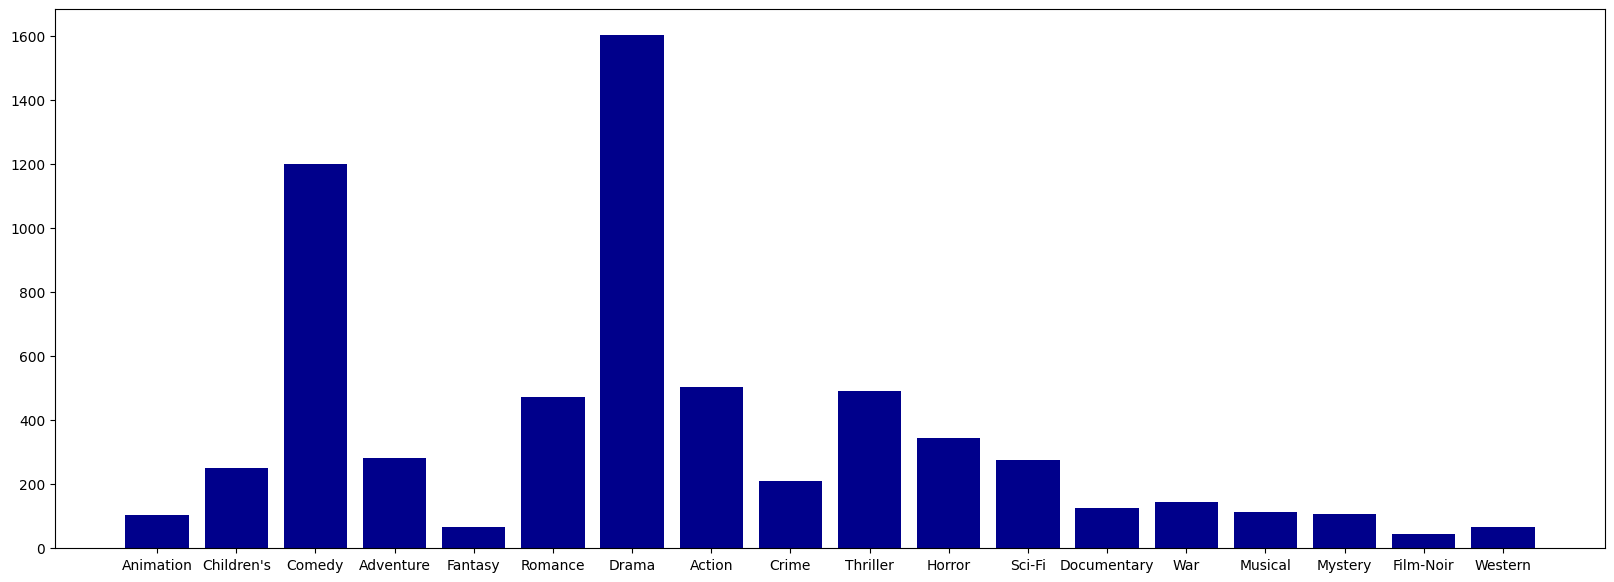

In [4]:
plt.figure(figsize=(20,7))
generlist = movies['genres'].apply(lambda generlist_movie : str(generlist_movie).split("|"))
geners_count = {}

for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
#geners_count.pop("(no genres listed)")
plt.bar(geners_count.keys(),geners_count.values(),color='darkblue')

### Distribution of users rating

C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_15788\2481991749.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ratings["rating"]);


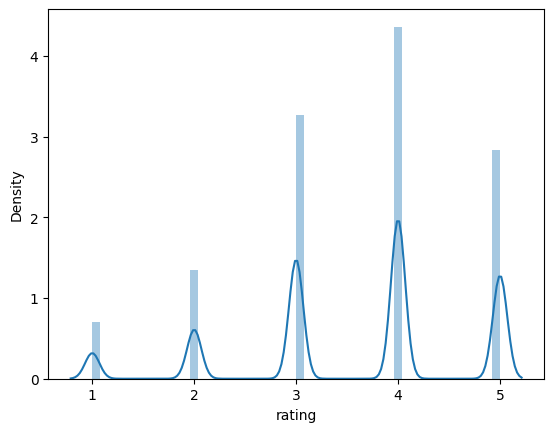

In [5]:
sns.distplot(ratings["rating"]);

In [6]:
print("Shape of frames: \n"+ " Rating DataFrame"+ str(ratings.shape)+"\n Movies DataFrame"+ str(movies.shape))

Shape of frames: 
 Rating DataFrame(1000209, 4)
 Movies DataFrame(3883, 3)


In [7]:
# Count how many ratings are in each category (1 star, 2 star, ect)
grouped = pd.DataFrame(ratings.groupby(['rating'])['movie_id'].count())
grouped.rename(columns={'movie_id':'rating_count'}, inplace=True)

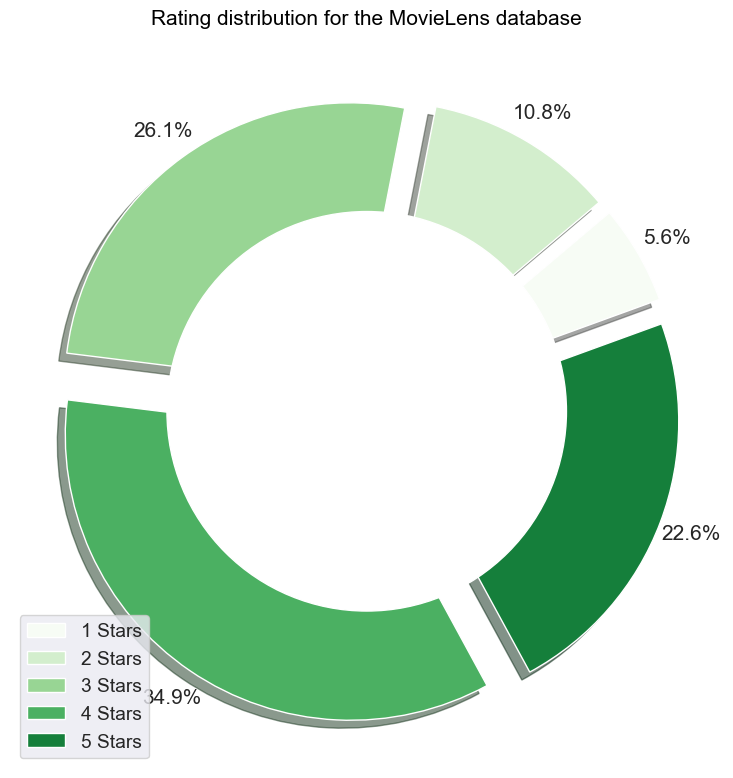

In [8]:
# Creating plots 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create colour palette
labels = ['1 Stars', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
theme = plt.get_cmap('Greens')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 shadow=True,
                 startangle=20,
                 pctdistance=1.115,
                 explode=(0.1, 0.1, 0.1, 0.1, 0.1))
   
# Turn pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display donut plot with legend
plt.legend(pie[0], labels, loc="lower left")
ax.set_title('Rating distribution for the MovieLens database\n', fontsize=15)
plt.tight_layout()
plt.show()

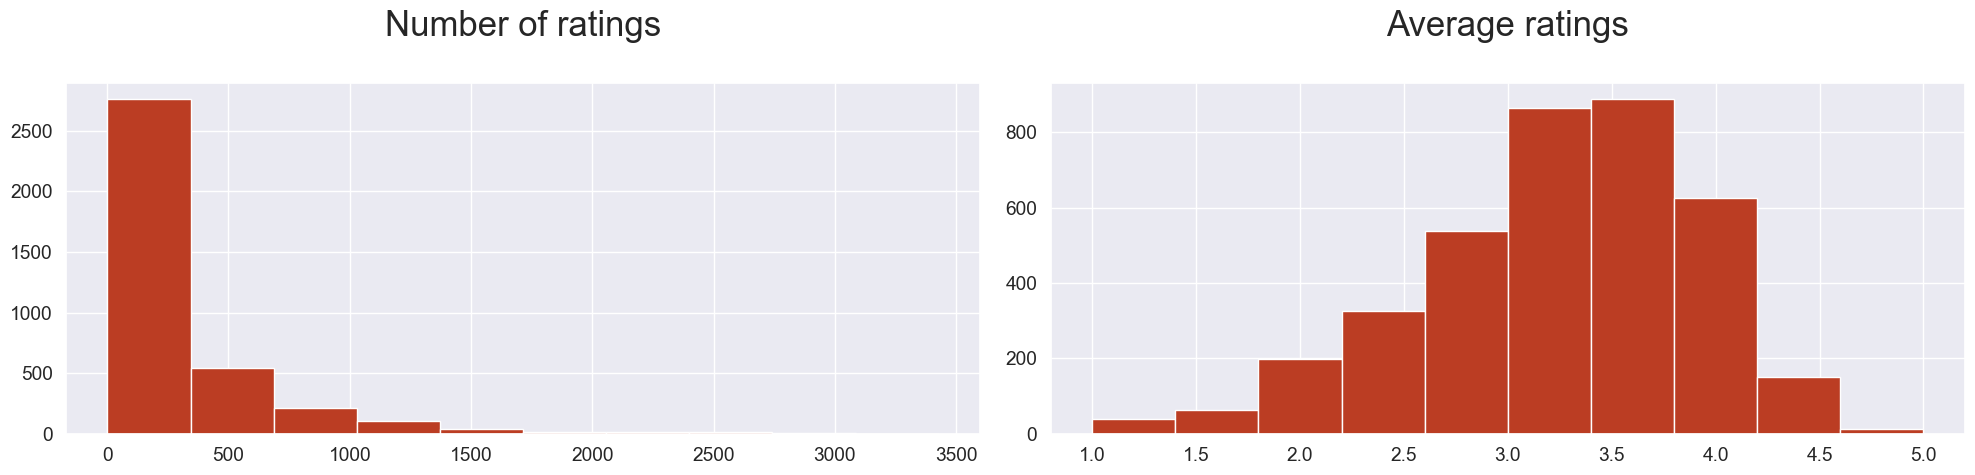

In [8]:
# Determine the average rating and number of ratings for each movie
ratings_mean_count = pd.DataFrame(ratings.groupby(['movie_id'])[['rating']].mean())
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby(['movie_id'])['rating'].count())
ratings_mean_count['popularity'] = pd.DataFrame(ratings.groupby(['movie_id'])['rating'].count()*ratings.groupby(['movie_id'])['rating'].mean())

# Create a plot of the number of ratings 
f, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].hist(ratings_mean_count['rating_counts'], bins=10, color='#bb3d23')
axarr[0].set_title('Number of ratings\n', fontsize=25)

# Create a plot showing the average ratings distribution 
axarr[1].hist(ratings_mean_count['rating'], bins=10, color='#bb3d23')
axarr[1].set_title('Average ratings\n', fontsize=25)

# Display both plots
plt.tight_layout()
plt.show()

In [9]:
# Extract and display the 10 most popular films in the dataset 
ratings_mean_count = ratings_mean_count.sort_values(by='popularity', ascending=False).head(15)
ratings_mean_count.head(10)

,rating,rating_counts,popularity
movie_id,,,
2858,4.317386,3428,14800.0
260,4.453694,2991,13321.0
1196,4.292977,2990,12836.0
1210,4.022893,2883,11598.0
2028,4.337354,2653,11507.0
1198,4.477725,2514,11257.0
593,4.351823,2578,11219.0
2571,4.315830,2590,11178.0
2762,4.406263,2459,10835.0


In [10]:
movie_ID = ratings_mean_count.index[0]
movie_top = movies.loc[movies['movie_id'] == movie_ID].iloc[0]
print('Top movie '+ movie_top[1])

Top movie American Beauty (1999)


C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_15788\1080051201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.rating == 0.5] = 2
C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_15788\1080051201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.rating == 1] = 2
C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_15788\1080051201.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating

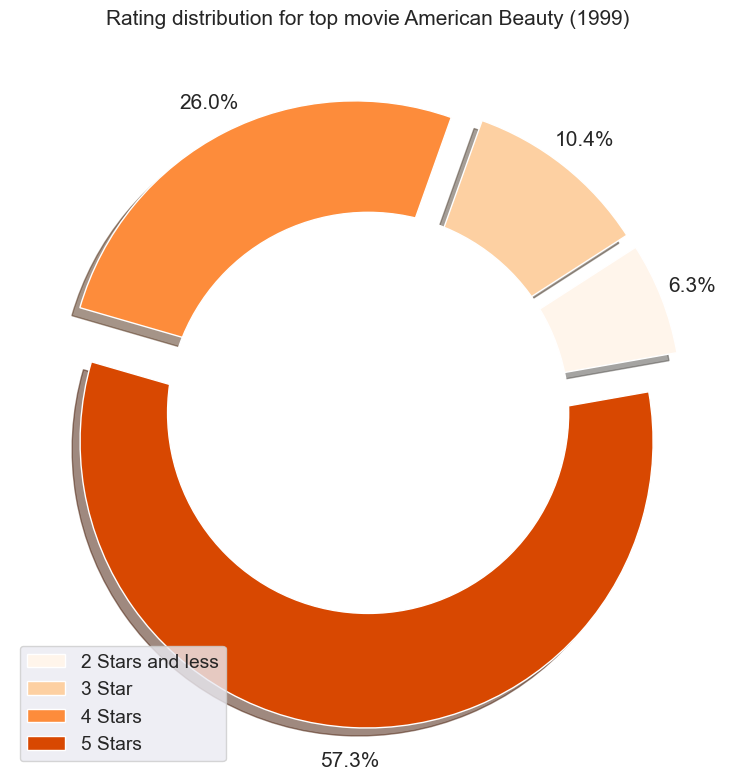

In [12]:
# Extract ratings for top movie
top = ratings[ratings['movie_id'] == movie_ID]

# Group all 2 star and lower ratings together
top.rating[top.rating == 0.5] = 2 
top.rating[top.rating == 1] = 2 
top.rating[top.rating == 1.5] = 2 

# Count how many ratings are in each category: 1 star, 2 star, ect
grouped = pd.DataFrame(top.groupby(['rating'])['movie_id'].count())
grouped.rename(columns={'movie_id':'rating_count'}, inplace=True)

# Create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create the colour palette
labels = ['2 Stars and less', '3 Star', '4 Stars', '5 Stars']
theme = plt.get_cmap('Oranges')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create the pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 #labels=labels, 
                 shadow=True,
                 startangle=10,
                 pctdistance=1.115,
                 explode = (0.1, 0.1, 0.1, 0.1))
   
# Turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the donut chart with a legend
ax.set_title('Rating distribution for top movie '+ str(movie_top[1]) +'\n', fontsize=15)
plt.legend(pie[0], labels, loc="lower left")
plt.tight_layout()
plt.show()

C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_7196\476024446.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.rating == 0.5] = 2
C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_7196\476024446.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.rating == 1] = 2
C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_7196\476024446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top.rating[top.r

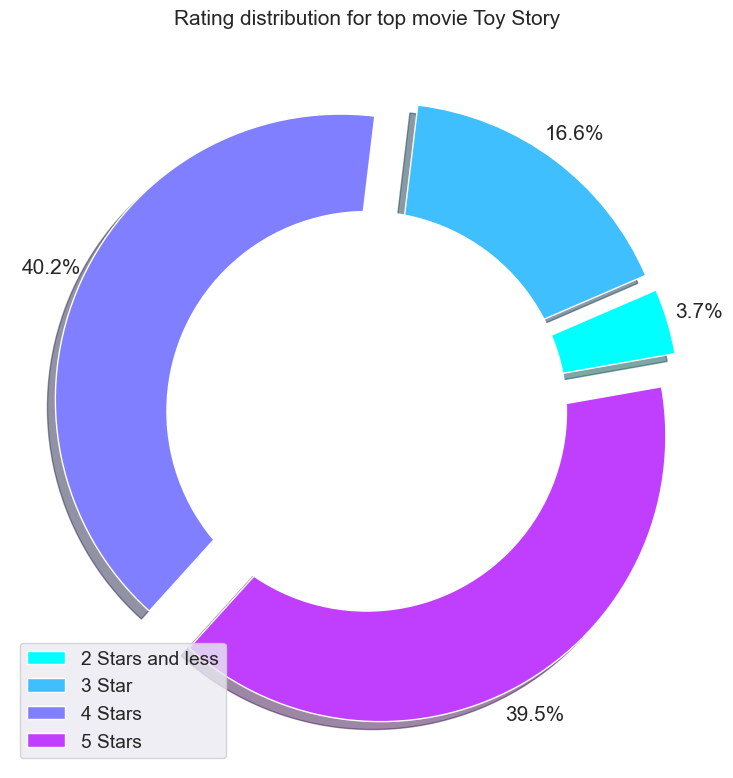

In [15]:
movie_ID = 1 # Toy Story movie_ID = 1
top = ratings[ratings['movie_id'] == movie_ID]

# Group all 2 star and lower ratings together
top.rating[top.rating == 0.5] = 2 
top.rating[top.rating == 1] = 2 
top.rating[top.rating == 1.5] = 2 

# Count how many ratings are in each category: 1 star, 2 star, ect
grouped = pd.DataFrame(top.groupby(['rating'])['movie_id'].count())
grouped.rename(columns={'movie_id':'rating_count'}, inplace=True)

# Create the figure
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(122)
    
# Create the colour palette
labels = ['2 Stars and less', '3 Star', '4 Stars', '5 Stars']
theme = plt.get_cmap('cool')
ax.set_prop_cycle("color", [theme(1. * i / len(labels))
                                 for i in range(len(labels))])
sns.set(font_scale=1.25)

# Create the pie chart
pie = ax.pie(grouped['rating_count'],
                 autopct='%1.1f%%',
                 #labels=labels, 
                 shadow=True,
                 startangle=10,
                 pctdistance=1.115,
                 explode = (0.1, 0.1, 0.1, 0.1))
   
# Turn the pie chart into a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Display the donut chart with a legend
ax.set_title('Rating distribution for top movie '+ 'Toy Story' +'\n', fontsize=15)
#ax.set_title('Rating distribution for top movie '+ str(movie_top[1]) +'\n', fontsize=15)
plt.legend(pie[0], labels, loc="lower left")
plt.tight_layout()
plt.show()

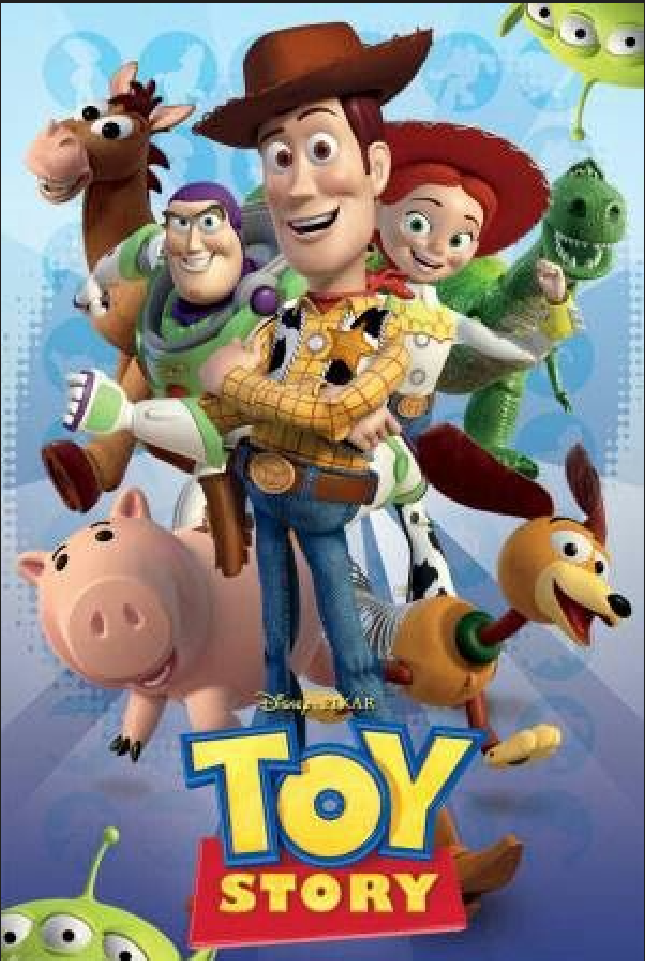

![Screenshot 2022-12-26.PNG](attachment:Screenshot 2022-12-26.PNG)

In [13]:
genres = pd.read_csv(r"https://raw.githubusercontent.com/JohnTan38/Recommender/main/dat/movie_genres.csv") #visualization
users_1 = pd.read_csv(r"https://raw.githubusercontent.com/JohnTan38/Recommender/main/dat/users_1.csv")
users_ratings = pd.merge(ratings, users_1, on='user_id')

labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79'] #binning the users
users_ratings['age_group'] = pd.cut(users_ratings.Age, range(0, 81, 10), right=False, labels=labels)
users_ratings[['Age', 'age_group']].drop_duplicates()[:10]

,Age,age_group
0,24,20-29
53,53,50-59
182,23,20-29
254,33,30-39
452,42,40-49
523,57,50-59
554,36,30-39
693,29,20-29
1200,39,30-39
1337,28,20-29


In [14]:
mov_user_gen = pd.merge(users_ratings, genres, on='movie_id')
output = mov_user_gen[['age_group', 'genre', 'user_id']]
output = output.groupby(['age_group', 'genre']).count()

In [15]:
g = output['user_id'].groupby(level=0, group_keys=False) # group by the first level of index
#res = g.apply(lambda x: x.order(ascending=False)) # sort within each group in descending order 
res = g.apply(lambda x: x.sort_values(ascending=False))
res = pd.DataFrame(res) #convert series to dataframe 

res = res.reset_index()
res = res.groupby(['age_group']).first()
res = res.rename(columns={'user_id':'Total Users'})
res = res.reset_index()

genre = res['genre']

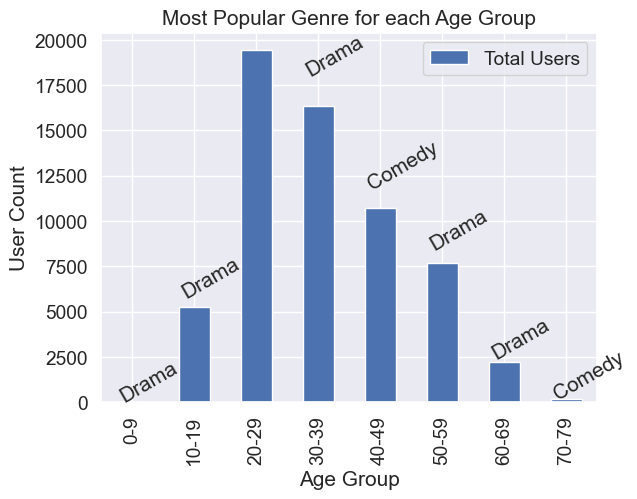

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
ax = res.plot.bar(x='age_group', y=['Total Users'] , title='Most Popular Genre for each Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('User Count')
i = 0
for p in ax.patches:
    height = p.get_height()
    ax.annotate(genre[i] , xy=((p.get_x()), (p.get_height()*1.1)), rotation=30)
    i = i +1

#plt.savefig(output_path + '\\age_group_genre.jpeg')
plt.show()

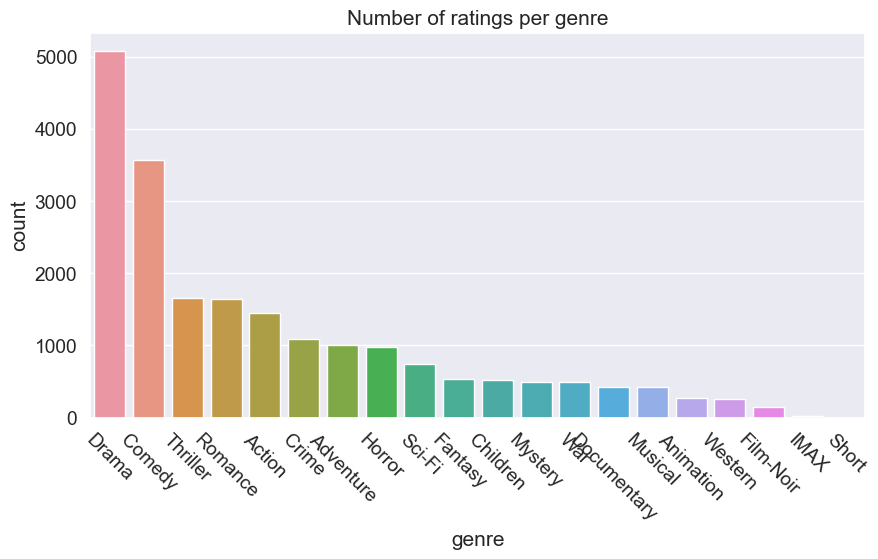

In [17]:
plt.subplots(figsize=(10,5))
sns.countplot(x='genre', order = genres['genre'].value_counts().index, data=genres);
plt.xticks(rotation=-45)
plt.title('Number of ratings per genre');
plt.show()

In [18]:
path_dat = f"https://raw.githubusercontent.com/JohnTan38/Recommender/main/dat/"
unames = ['user_id', 'gender', 'age', 'occupation', 'zipcode']
users_dat = pd.read_table(path_dat + 'users.dat.txt', sep='::', header=None, names=unames,engine='python')

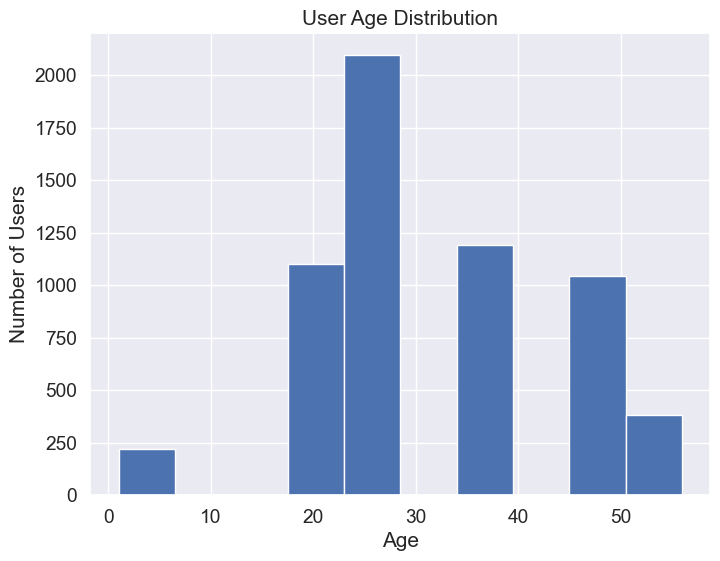

In [19]:
# user age distribution
plt.figure(figsize=(8,6))
users_dat.age.hist()
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

In [20]:
mnames = ['movie_id','title','genres']
movies_dat = pd.read_table(path_dat +"movies.dat.txt", sep='::', header=None, names=mnames,engine='python', encoding='latin-1')
movies_dat_ratings = pd.merge(movies_dat, ratings, on='movie_id')
movies_dat_ratings['genres'].unique() #unique genres

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", "Children's|Comedy",
       'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventure|Crime', 'Crime', 'Drama

In [22]:
movies_dat_ratings_users_dat = pd.merge(movies_dat_ratings, users_dat, on='user_id')
movies_dat_ratings_users_dat_select = movies_dat_ratings_users_dat[['gender', 'age', 'occupation', 'rating', 'genres']]

Genre = movies_dat_ratings_users_dat_select['genres']
Genre = Genre.str.get_dummies().add_prefix('genres_')
movies_ratings_genres = pd.concat(
    [movies_dat_ratings_users_dat_select.drop(
        ['genres'],
        axis=1
    ),
     Genre],
    axis=1,
    
)

movies_ratings_genres = pd.get_dummies(
    movies_ratings_genres,
    columns=['gender']
)

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn import metrics

lineReg = LinearRegression(
    copy_X=True,
    fit_intercept=True,
    n_jobs=1,
    normalize=False
)

movies_ratings_users_sample = movies_ratings_genres.sample(
    n=50000,
    random_state=0
)
movies_ratings_users_sample.head()

,age,occupation,rating,genres_Action,genres_Adventure,genres_Animation,genres_Children's,genres_Comedy,genres_Crime,genres_Documentary,...,genres_Horror,genres_Musical,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Thriller,genres_War,genres_Western,gender_F,gender_M
324271,18,4,4,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
818637,18,4,3,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
148677,18,14,5,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
778790,50,7,4,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
525489,25,2,5,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [24]:
X = movies_ratings_users_sample.drop('rating', axis=1)
y = movies_ratings_users_sample['rating']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=0
)

In [25]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

In [26]:
#Evaluation. Age and occupation are main factors that affect movies ratings
print(
    'y-intercept: ',
    linear_reg.intercept_
)
print(
    'Beta coefficients: ',
    linear_reg.coef_
)
print(
    'Mean Abs Error  MAE: ',
    metrics.mean_absolute_error(y_test, y_pred)
)
print(
    'Mean Sq Error  MSE: ',
    metrics.mean_squared_error(y_test, y_pred)
)
print(
    'Root Mean Sq Error RMSE:',
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))
)
print(
    'r2 value: ',
    metrics.r2_score(y_test, y_pred)
)

y-intercept:  3.371413755515966
Beta coefficients:  [ 0.00406322  0.00098825 -0.0933231   0.00822898  0.41190314 -0.32536968
 -0.00937548  0.07845926  0.43311855  0.22781148  0.07368389  0.3951835
 -0.29085584  0.12523149  0.02288591  0.00234758 -0.01347635  0.06128953
  0.30880281  0.14777492  0.01440465 -0.01440465]
Mean Abs Error  MAE:  0.8978299534841195
Mean Sq Error  MSE:  1.1977731707567232
Root Mean Sq Error RMSE: 1.0944282391992282
r2 value:  0.03795269985311833


In [27]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

R = Ratings.to_numpy()
user_ratings_mean = np.mean(R, axis = 1) #normalize by each user's mean, convert from df to np array
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [28]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 95.5%


In [29]:
from scipy.sparse.linalg import svds #setting up SVD
U, sigma, Vt = svds(Ratings_demeaned, k = 50) #latent features (k=50) to approximate original ratings matrix

sigma = np.diag(sigma) #leverage matrix multiplication to get predictions, convert to diagonal matrix
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 147.18581225    0.            0.         ...    0.
     0.            0.        ]
 [   0.          147.62154312    0.         ...    0.
     0.            0.        ]
 [   0.            0.          148.58855276 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  574.46932602
     0.            0.        ]
 [   0.            0.            0.         ...    0.
   670.41536276    0.        ]
 [   0.            0.            0.         ...    0.
     0.         1544.10679346]]


In [30]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1) #add user means, get actual rating

In [31]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


In [32]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [33]:
#to return the movies with the highest predicted rating that the specified user hasn't already rated

already_rated, predictions = recommend_movies(preds, 2696, movies, ratings, 20)

User 2696 has already rated 20 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [34]:
merge_ratings_movies = pd.merge(movies, ratings, on='movie_id', how='inner')

In [35]:
# Top 20 movies that User 2696 has rated 
already_rated.head(20)

,user_id,movie_id,rating,timestamp,title,genres
8,2696,800,5,973308842,Lone Star (1996),Drama|Mystery
0,2696,1258,4,973308710,"Shining, The (1980)",Horror
7,2696,1892,4,973308904,"Perfect Murder, A (1998)",Mystery|Thriller
18,2696,1092,4,973308886,Basic Instinct (1992),Mystery|Thriller
16,2696,1783,4,973308865,Palmetto (1998),Film-Noir|Mystery|Thriller
12,2696,2389,4,973308710,Psycho (1998),Crime|Horror|Thriller
11,2696,3176,4,973308865,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller
10,2696,1711,4,973308904,Midnight in the Garden of Good and Evil (1997),Comedy|Crime|Drama|Mystery
6,2696,1805,4,973308886,Wild Things (1998),Crime|Drama|Mystery|Thriller
5,2696,1645,4,973308904,"Devil's Advocate, The (1997)",Crime|Horror|Mystery|Thriller


In [36]:
# Top 20 movies that User 2696 would likely enjoy
predictions

,movie_id,title,genres
49,50,"Usual Suspects, The (1995)",Crime|Thriller
46,47,Seven (Se7en) (1995),Crime|Thriller
1228,1252,Chinatown (1974),Film-Noir|Mystery|Thriller
603,608,Fargo (1996),Crime|Drama|Thriller
1671,1732,"Big Lebowski, The (1998)",Comedy|Crime|Mystery|Thriller
2305,2391,"Simple Plan, A (1998)",Crime|Thriller
1378,1407,Scream (1996),Horror|Thriller
910,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller
1668,1729,Jackie Brown (1997),Crime|Drama
1825,1909,"X-Files: Fight the Future, The (1998)",Mystery|Sci-Fi|Thriller


In [ ]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

# Define the dictionary used to produce the genre wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
import wordcloud
from wordcloud import WordCloud, STOPWORDS

genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [37]:
merge_ratings_movies.head(2)

,movie_id,title,genres,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008


In [38]:
merge_ratings_movies.shape

(1000209, 6)

Grouping the rating based on user

In [39]:
ratings_grouped_by_users = merge_ratings_movies.groupby('user_id').agg([np.size, np.mean])

C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_15788\1369917194.py:1: FutureWarning: ['title', 'genres'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  ratings_grouped_by_users = merge_ratings_movies.groupby('user_id').agg([np.size, np.mean])


In [40]:
ratings_grouped_by_users.head(2)

movie_id              rating           timestamp              
            size         mean   size      mean      size          mean
user_id                                                               
1             53  1560.547170     53  4.188679        53  9.784297e+08
2            129  1784.015504    129  3.713178       129  9.782993e+08

In [41]:
ratings_grouped_by_users = ratings_grouped_by_users.drop('movie_id', axis = 1)

### Top 10 users who have rated most of the movies

<AxesSubplot: xlabel='user_id'>

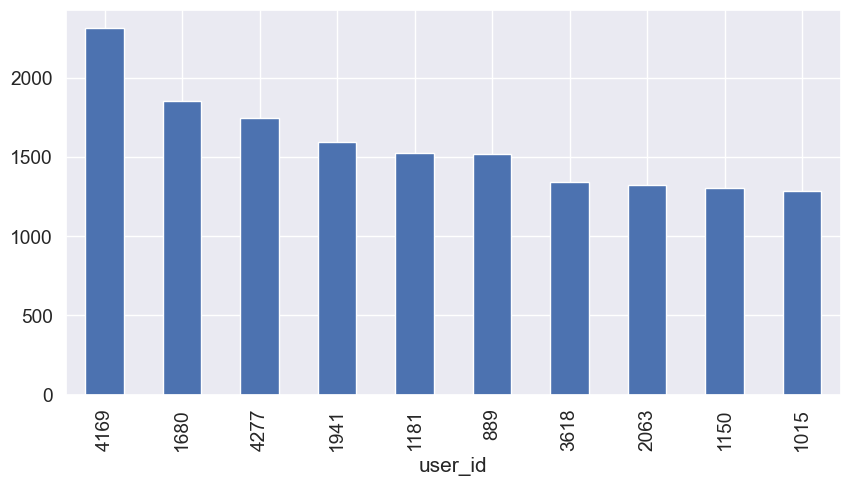

In [42]:
ratings_grouped_by_users['rating']['size'].sort_values(ascending=False).head(10).plot(kind='bar', figsize = (10,5))

In [43]:
ratings_grouped_by_movies = merge_ratings_movies.groupby('movie_id').agg([np.mean], np.size)

C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_15788\2202001479.py:1: FutureWarning: ['title', 'genres'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  ratings_grouped_by_movies = merge_ratings_movies.groupby('movie_id').agg([np.mean], np.size)


In [44]:
ratings_grouped_by_movies.shape

(3706, 3)

In [45]:
ratings_grouped_by_movies.head(3)

,user_id,rating,timestamp
,mean,mean,mean
movie_id,,,
1,3053.819933,4.146846,9.705586e+08
2,3027.977175,3.201141,9.717322e+08
3,2632.156904,3.016736,9.734544e+08


In [46]:
ratings_grouped_by_movies = ratings_grouped_by_movies.drop('user_id', axis=1)

### Movies with high average rating

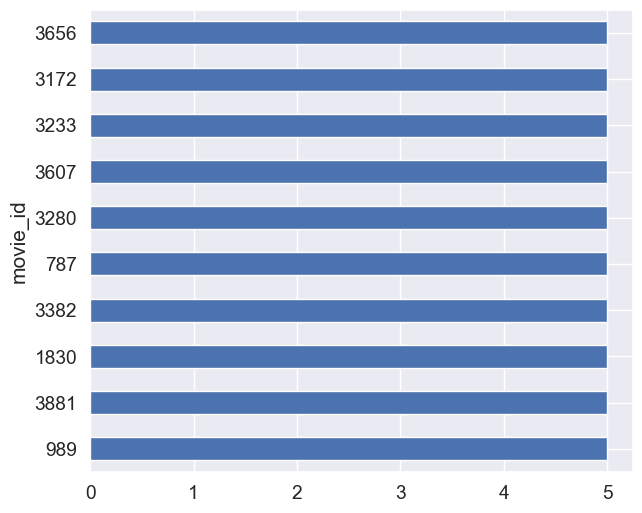

In [47]:
ratings_grouped_by_movies['rating']['mean'].sort_values(ascending=False).head(10).plot(kind='barh', figsize=(7,6));

### Movies with low average rating

In [48]:
low_rated_movies_filter = ratings_grouped_by_movies['rating']['mean']< 1.5

In [49]:
low_rated_movies = ratings_grouped_by_movies[low_rated_movies_filter]

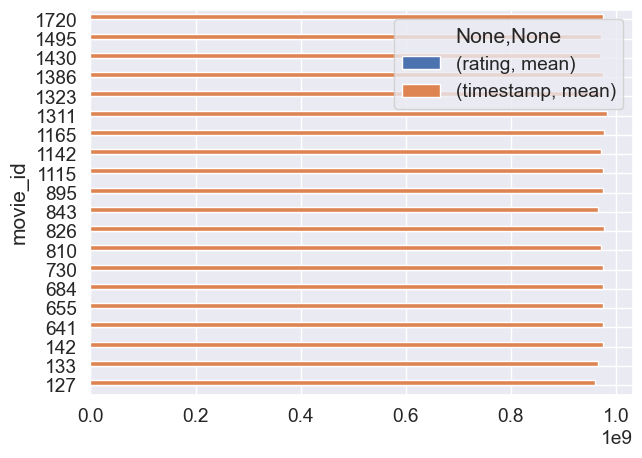

In [50]:
low_rated_movies.head(20).plot(kind='barh', figsize=(7,5));

In [51]:
low_rated_movies.head()

,rating,timestamp
,mean,mean
movie_id,,
127,1.0,960795494.0
133,1.0,965013057.0
142,1.0,974836640.0
641,1.0,974878851.0
655,1.0,974478452.0


# Content based filtering
The concepts of Term Frequency (TF) and Inverse Document Frequency (IDF) are used in information retrieval systems and also content based filtering mechanisms (such as a content based recommender). They are used to determine the relative importance of a document / article / news item / movie etc.

### Term Frequency (TF) and Inverse Document Frequency (IDF)
TF is simply the frequency of a word in a document. IDF is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

We will consider genres as an important parameter to recommend user the movie he watches based on generes of movie user has already watched.

![](https://mungingdata.files.wordpress.com/2017/11/equation.png?w=430&h=336)

For calculating distances, many similarity coefficients can be calculated. Most widely used similarity coefficients are Euclidean, Cosine, Pearson Correlation etc.

**Cosine similarity**
is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them.
Given two vectors of attributes, A and B, the cosine similarity, cos(θ), is represented using a dot product and magnitude as
Inline-style: 
![alt text](https://alexn.org/assets/img/cosine-similarity.png)

We will use cosine distance here. Here we are insterested in similarity. That means higher the value more similar they are. But as the function gives us the distance, we will deduct it from 1.

In [52]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')

#Replace NaN with an empty string
movies['genres'] = movies['genres'].replace(to_replace="(no genres listed)", value="")

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies['genres'])
# print(tfidf_movies_genres.get_feature_names())
# Compute the cosine similarity matrix
# print(tfidf_movies_genres_matrix.shape)
# print(tfidf_movies_genres_matrix.dtype)
cosine_sim_movies = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)
# print(cosine_sim_movies)

In [53]:
def get_recommendations_based_on_genres(movie_title, cosine_sim_movies=cosine_sim_movies):
    """
    Calculates top 2 movies to recommend based on given movie titles genres. 
    :param movie_title: title of movie to be taken for base of recommendation
    :param cosine_sim_movies: cosine similarity between movies 
    :return: Titles of movies recommended to user
    """
    # Get the index of the movie that matches the title
    idx_movie = movies.loc[movies['title'].isin([movie_title])]
    idx_movie = idx_movie.index
    
    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores_movies = list(enumerate(cosine_sim_movies[idx_movie][0]))
    
    # Sort the movies based on the similarity scores
    sim_scores_movies = sorted(sim_scores_movies, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores_movies = sim_scores_movies[1:3]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores_movies]
    
    # Return the top 2 most similar movies
    return movies['title'].iloc[movie_indices]

In [54]:
get_recommendations_based_on_genres("Father of the Bride Part II (1995)")

18    Ace Ventura: When Nature Calls (1995)
37                      It Takes Two (1995)
Name: title, dtype: object

In [55]:
def get_recommendation_content_model(userId):
    """
    Calculates top movies to be recommended to user based on movie user has watched.  
    :param userId: userid of user
    :return: Titles of movies recommended to user
    """
    recommended_movie_list = []
    movie_list = []
    df_rating_filtered = ratings[ratings["user_id"]== userId]
    for key, row in df_rating_filtered.iterrows():
        movie_list.append((movies["title"][row["movie_id"]==movies["movie_id"]]).values) 
    for index, movie in enumerate(movie_list):
        for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():
            recommended_movie_list.append(movie_recommended)

    # removing already watched movie from recommended list    
    for movie_title in recommended_movie_list:
        if movie_title in movie_list:
            recommended_movie_list.remove(movie_title)
    
    return set(recommended_movie_list)
get_recommendation_content_model(1)

C:\Users\guest_dpdq7co\AppData\Local\Temp\ipykernel_15788\100505234.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for key, movie_recommended in get_recommendations_based_on_genres(movie[0]).iteritems():


{'Ace Ventura: When Nature Calls (1995)',
 'Aladdin and the King of Thieves (1996)',
 'Amateur (1994)',
 'American Tail, An (1986)',
 'American in Paris, An (1951)',
 'Assassins (1995)',
 'Beauty and the Beast (1991)',
 'Bedknobs and Broomsticks (1971)',
 'Beetlejuice (1988)',
 'Beyond Rangoon (1995)',
 'Bogus (1996)',
 'Carrington (1995)',
 'Coneheads (1993)',
 'Dark Crystal, The (1982)',
 'Emerald Forest, The (1985)',
 'Faust (1994)',
 'Full Metal Jacket (1987)',
 'Gumby: The Movie (1995)',
 'Heaven & Earth (1993)',
 'I Married A Strange Person (1997)',
 'Inspector General, The (1949)',
 'It Takes Two (1995)',
 'Jack and Sarah (1995)',
 'Jewel of the Nile, The (1985)',
 'Jungle Book, The (1967)',
 'Karate Kid, Part II, The (1986)',
 'Kicking and Screaming (1995)',
 'Kiss of Death (1995)',
 'Lady and the Tramp (1955)',
 'Leaving Las Vegas (1995)',
 'Little Mermaid, The (1989)',
 'Little Princess, A (1995)',
 "Midsummer Night's Dream, A (1999)",
 'Modern Affair, A (1995)',
 'Muppet Chr

# Model evaluation with KNN
Here the model is evaluated on based of if there is exact match of genres with the genres of movie which is already watch by user 

In [56]:
from sklearn.neighbors import KNeighborsClassifier  
def get_movie_label(movie_id):
    """
    Get the cluster label to which movie belongs by KNN algorithm.  
    :param movie_id: movie id
    :return: genres label to movie belong
    """
    classifier = KNeighborsClassifier(n_neighbors=5)
    x= tfidf_movies_genres_matrix
    y = movies.iloc[:,-1]
    classifier.fit(x, y)
    y_pred = classifier.predict(tfidf_movies_genres_matrix[movie_id])
    return y_pred

In [57]:
true_count = 0
false_count = 0
def evaluate_content_based_model():
    """
    Evaluate content based model.  
    """
    for key, colums in movies.iterrows():
        movies_recommended_by_model = get_recommendations_based_on_genres(colums["title"])
        predicted_genres  = get_movie_label(movies_recommended_by_model.index)
        for predicted_genre in predicted_genres:
            global true_count, false_count
            if predicted_genre == colums["genres"]:
                true_count = true_count+1
            else:
#                 print(colums["genres"])
#                 print(predicted_genre)
                false_count = false_count +1
evaluate_content_based_model()
total = true_count + false_count
print("Hit:"+ str(true_count/total))
print("Fault:" + str(false_count/total))

Hit:0.9522276590265258
Fault:0.04777234097347412


In [58]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

# Collaborative Filtering
Types of collaborative filtering techniques
* Memory based 
 - User-Item Filtering
 - Item-Item Filtering
* Model based 
 - Matrix Factorization
 - Clustering
 - Deep Learning
 ![alt text](https://cdn-images-1.medium.com/max/1500/1*7uW5hLXztSu_FOmZOWpB6g.png)

## Memory Based Approach
 ![alt text](https://cdn-images-1.medium.com/max/1500/1*QvhetbRjCr1vryTch_2HZQ.jpeg)

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:

- **Jaccard Similarity**
- **Cosine Similarity** 
- **Pearson Similarity** 

## Item-Item Filtering
Item-item collaborative filtering, or item-based, or item-to-item, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings of those items.


Item-item collaborative filtering was invented and used by Amazon.com


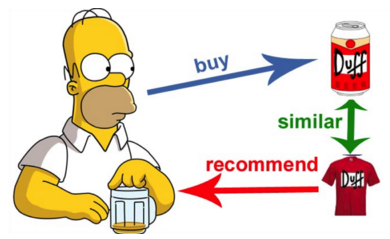

ITEM-ITEM collaborative filtering look for items that are similar to the articles that user has already rated and recommend most similar articles. But what does that mean when we say item-item similarity? In this case we don’t mean whether two items are the same by attribute like Fountain pen and pilot pen are similar because both are pen. Instead, what similarity means is how people treat two items the same in terms of like and dislike.

It is quite similar to previous algorithm, but instead of finding user’s look-alike, we try finding movie’s look-alike. Once we have movie’s look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

## Implementation of Item-Item Filtering

In [59]:
movies_ratings=pd.merge(movies, ratings)
movies_ratings

,movie_id,title,genres,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474
...,...,...,...,...,...,...
1000204,3952,"Contender, The (2000)",Drama|Thriller,5812,4,992072099
1000205,3952,"Contender, The (2000)",Drama|Thriller,5831,3,986223125
1000206,3952,"Contender, The (2000)",Drama|Thriller,5837,4,1011902656
1000207,3952,"Contender, The (2000)",Drama|Thriller,5927,1,979852537


Here Pivot table function is used as we want one to one maping between movies, user and their rating. 
So by default pivot_table command takes average if we have multiple values of one combination.

In [60]:
ratings_matrix_items = movies_ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )
ratings_matrix_items.shape

(3706, 6040)

In [61]:
ratings_matrix_items

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3704,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,3696,3697,3698,3699,3700,3701,3702,3703,3704,3705
0,0.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
1,0.390349,0.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
2,0.267943,0.240946,0.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
3,0.178789,0.155457,0.192788,0.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
4,0.256569,0.249970,0.308290,0.271990,0.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,0.309676,0.213650,0.190575,0.118902,0.174554,0.236447,0.191689,0.090387,0.092347,0.237227,...,0.183859,0.053539,0.109062,0.210272,0.078341,0.000000,0.329339,0.168234,0.122279,0.363838
3702,0.186633,0.140781,0.104837,0.096318,0.092403,0.201419,0.117660,0.080523,0.099554,0.136374,...,0.244371,0.098568,0.070933,0.160150,0.107063,0.329339,0.000000,0.302649,0.199337,0.347805
3703,0.093479,0.087013,0.062258,0.022588,0.051633,0.115331,0.059262,0.084976,0.004956,0.097170,...,0.126068,0.211891,0.057350,0.124186,0.095905,0.168234,0.302649,0.000000,0.202809,0.234638
3704,0.042829,0.026063,0.010073,0.024769,0.010750,0.029136,0.036102,0.072141,0.000000,0.018359,...,0.170983,0.132019,0.086057,0.104873,0.015847,0.122279,0.199337,0.202809,0.000000,0.192972


Below function will take the movie name as a input and will find the movies which are similar to this movie.
This function first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe so that we can get the similarity of the movie with all other movies.

In [63]:
def item_similarity(movieName): 
    """
    recomendates similar movies
   :param data: name of the movie 
   """
    try:
        #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
        user_inp=movieName
        inp=movies[movies['title']==user_inp].index.tolist()
        inp=inp[0]

        movies['similarity'] = ratings_matrix_items.iloc[inp]
        movies.columns = ['movie_id', 'title', 'release_date','similarity']
    except:
        print("Sorry, the movie is not in the database!")

Here we provide the user id of the user for which we have to recommend movies.
Then we find the movies which are rated 5 or 4.5 by the user for whom we want to recommend movies.
We are finding this because as we know that in Item-Item similarity approach we recommended movies to the user based on his previous selection.
So to foster our algorithm we are finding movies which are liked by the user most and on bases of that we will recommend movies with are similar to movies highly rated by the user.
Then our function has appended the similarity of the movie highly rated by the user to our movies data frame.
Now we will sort the frame as per the similarity in descending order so that we can get the movies which are highly similar to movie highly rated bu our customer.
Now we filter the movies which are most similar as per the similarity so if similarity is greater than 0.45 then we are considering the movies.
Now the function goes ahead and see which all movies user has seen and then filter out the movies which he has not seen and than recommended that movies to him.

In [64]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user_movie = movies_ratings[(movies_ratings.user_id==user_id) & movies_ratings.rating.isin([5,4.5])][['title']]
    user_movie = user_movie.iloc[0,0]
    item_similarity(user_movie)
    sorted_movies_as_per_userChoice = movies.sort_values( ["similarity"], ascending = False )
    sorted_movies_as_per_userChoice = sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
    recommended_movies = list()
    df_recommended_item = pd.DataFrame()
    user2Movies = ratings[ratings['user_id']== user_id]['movie_id']
    for movieId in sorted_movies_as_per_userChoice:
            if movieId not in user2Movies:
                df_new = ratings[(ratings.movie_id==movieId)]
                df_recommended_item=pd.concat([df_recommended_item,df_new])
            best10 = df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
    return best10['movie_id']

In [65]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(movies[movies['movie_id']==id]['title'])
    return movie_titles

In [66]:
user_id=2696
print("Recommended movies,:\n",movieIdToTitle(recommendedMoviesAsperItemSimilarity(user_id)))

Recommended movies,:
 [318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object, 318    Strawberry and Chocolate (Fresa y chocolate) (...
Name: title, dtype: object]


## User-Item Filtering
The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.



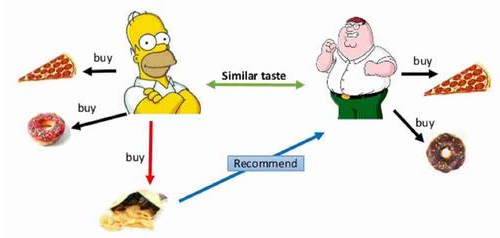

Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

## Implementation of User-Item Filtering

In similar way as we did for ItemItem similarity we will create a matrix but here we will keep rows as user and columns as movieId as we want a vector of different users.
Then in similar ways we will find distance and similarity between users.

In [67]:
ratings_matrix_users = movies_ratings.pivot_table(index=['user_id'],columns=['movie_id'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna(0, inplace = True)
movie_similarity = 1 - pairwise_distances( ratings_matrix_users, metric="cosine" )
np.fill_diagonal(movie_similarity, 0) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039
0,0.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.255288,...,0.170588,0.082006,0.069807,0.033663,0.114877,0.186329,0.135979,0.000000,0.174604,0.133590
1,0.096382,0.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.203337,0.190198,0.226861,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.228241,0.206274,0.066118,0.066457,0.218276
2,0.120610,0.151479,0.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.213655,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143264,0.107744,0.120234,0.094675,0.133144
3,0.132455,0.171176,0.151227,0.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120738,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.170583,0.127464,0.062907,0.064634,0.137968
4,0.090158,0.114394,0.062907,0.045094,0.000000,0.047449,0.126257,0.220817,0.261330,0.117052,...,0.100652,0.035732,0.061806,0.054151,0.179083,0.293365,0.172686,0.020459,0.027689,0.241437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0.186329,0.228241,0.143264,0.170583,0.293365,0.093583,0.122441,0.227400,0.239607,0.338072,...,0.131294,0.209843,0.186426,0.103431,0.267405,0.000000,0.341462,0.124174,0.219115,0.411891
6036,0.135979,0.206274,0.107744,0.127464,0.172686,0.065788,0.111673,0.144395,0.225055,0.246902,...,0.142309,0.276134,0.129985,0.118749,0.141676,0.341462,0.000000,0.049015,0.252146,0.428240
6037,0.000000,0.066118,0.120234,0.062907,0.020459,0.065711,0.000000,0.019242,0.093470,0.113789,...,0.108837,0.106897,0.040689,0.000000,0.063967,0.124174,0.049015,0.000000,0.161714,0.099300
6038,0.174604,0.066457,0.094675,0.064634,0.027689,0.167303,0.014977,0.044660,0.046434,0.296776,...,0.118776,0.250994,0.053750,0.102168,0.068399,0.219115,0.252146,0.161714,0.000000,0.228332


Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [68]:
ratings_matrix_users.idxmax(axis=1)

0       5342
1       3107
2       2999
3       4142
4       1483
        ... 
6035    1014
6036    2063
6037    2208
6038     930
6039    1631
Length: 6040, dtype: int64

In [69]:
ratings_matrix_users.idxmax(axis=1).sample(10, random_state = 10)

5720    5776
6011    5966
290     3750
1985    1255
1065    2744
413      436
3600    3270
4635    4845
1969    1904
5698    4883
dtype: int64

In [70]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()

In [71]:
df_similar_user.columns=['similarUser']
df_similar_user

,similarUser
0,5342
1,3107
2,2999
3,4142
4,1483
...,...
6035,1014
6036,2063
6037,2208
6038,930


Below function takes id of the user to whom we have to recommend movies. On basis of that, we find the user which is similar to that user and then filter the movies which are highly rated by the user to recommend them to given user.

In [72]:
movieId_recommended=list()
def getRecommendedMoviesAsperUserSimilarity(userId):
    """
     Recommending movies which user hasn't watched as per User Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    user2Movies = ratings[ratings['user_id']== userId]['movie_id']
    sim_user = df_similar_user.iloc[0,0]
    df_recommended = pd.DataFrame(columns=['movie_id','title','genres','user_id','rating','timestamp'])
    for movieId in ratings[ratings['user_id']== sim_user]['movie_id']:
        if movieId not in user2Movies:
            df_new = movies_ratings[(movies_ratings.user_id ==sim_user) & (movies_ratings.movie_id==movieId)]
            df_recommended = pd.concat([df_recommended,df_new])
        best10 = df_recommended.sort_values(['rating'], ascending = False )[1:10]  
    return best10['movie_id']

In [73]:
user_id=2696
recommend_movies= movieIdToTitle(getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you may like to watch are:\n")
print(recommend_movies)

Movies you may like to watch are:

[1366    Jaws (1975)
Name: title, dtype: object, 1885    Rocky (1976)
Name: title, dtype: object, 585    Terminator 2: Judgment Day (1991)
Name: title, dtype: object, 3458    Predator (1987)
Name: title, dtype: object, 3439    Outlaw Josey Wales, The (1976)
Name: title, dtype: object, 1212    Right Stuff, The (1983)
Name: title, dtype: object, 1250    Back to the Future (1985)
Name: title, dtype: object, 1255    Highlander (1986)
Name: title, dtype: object, 1568    Hunt for Red October, The (1990)
Name: title, dtype: object]


# Evaluating the model

In [74]:
def get_user_similar_movies(user1, user2):
    
    """
     Returning common movies and ratings of same for both the users
    :param user1,user2: user ids of 2 users need to compare
    :return: movieIds to user 
    """
    common_movies = movies_ratings[movies_ratings.user_id == user1].merge(
      movies_ratings[movies_ratings.user_id == user2],
      on = "movie_id",
      how = "inner" )
    common_movies.drop(['movie_id','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'], axis=1, inplace=True)
    return common_movies

In [75]:
get_user_similar_movies(587,2696)

,title_x,user_id_x,rating_x,user_id_y,rating_y
0,E.T. the Extra-Terrestrial (1982),587,3,2696,3
1,"Shining, The (1980)",587,4,2696,4
2,Back to the Future (1985),587,4,2696,2
3,L.A. Confidential (1997),587,2,2696,4


## Pros and Cons of two methods

Challenges with User similarity
- The challenge with calculating user similarity is the user need to have some prior purchases and should have rated them.
- This recommendation technique does not work for new users.
- The system need to wait until the user make some purchases and rates them. Only then similar users can be found and recommendations can be made. This is called cold start problem.

# Single Value Decomposition

Singular value decomposition is a method of decomposing a matrix into three other matrices:

<img src="https://cdn-images-1.medium.com/max/1600/0*i4rDKIAE0o1ZXtBd.">

<div align="center">
  (1)
</div>

Where:

    A is an m × n matrix
    U is an m × r orthogonal matrix
    S is an r × r diagonal matrix
    V is an r × n orthogonal matrix

<img src="https://cdn-images-1.medium.com/max/1600/0*mpQRslOtBoqfcdP7.">

Note how we’ve collapsed the diagonal matrix, S, into a vector, thus simplifying the expression into a single summation. The variables, {sᵢ}, are called singular values and are normally arranged from largest to smallest:

<img src="https://cdn-images-1.medium.com/max/1600/0*7J7tN93BocfX5ZbA.">

The columns of U are called left singular vectors, while those of V are called right singular vectors.

We know that U and V are orthogonal, that is:

<img src="https://cdn-images-1.medium.com/max/1600/0*SHyyI8TOYFxCbLbw.">

Where I is the identity matrix. Only the diagonals of the identity matrix are 1, with all other values being 0. Note that because U is not square we cannot say that U Transpose(U)=I, so U is only orthogonal in one direction.

Using the orthogonality property, we can rearrange (1) into the following pair of eigenvalue equations:

### Data reduction
A typical machine learning problem might have several hundred or more variables, while many machine learning algorithms will break down if presented with more than a few dozen. This makes singular value decomposition indispensable in ML for variable reduction.

We have already seen in Equation (6) how an SVD with a reduced number of singular values can closely approximate a matrix. This can be used for data compression by storing the truncated forms of U, S, and V in place of A and for variable reduction by replacing A with U.

## Matrix Factorization

Memory-based collaborative filtering approaches that compute distance relationships between items or users have these two major issues:

* It doesn’t scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities — which takes a lot of computations.
* Ratings matrices may be overfitting to noisy representations of user tastes and preferences. When we use distance based “neighborhood” approaches on raw data, we match to sparse low-level details that we assume represent the user’s preference vector instead of the vector itself.

<img src="https://cdn-images-1.medium.com/max/1600/1*bWAAyciKq580ArTix_O3nw.jpeg">

Thus we need to apply Dimensionality Reduction technique to derive the tastes and preferences from the raw data, otherwise known as doing <b>low-rank matrix factorization</b>.

   * We can discover hidden correlations / features in the raw data.
   * We can remove redundant and noisy features that are not useful.
   * We can interpret and visualize the data easier.
   * We can also access easier data storage and processing.


### Let's try out the same in Python

In [76]:
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 6040 | Number of movies = 3706


Now we want the format of our ratings matrix to be one row per user and one column per movie. To do so, we willl pivot ratings to get that and call the new variable Ratings (with a capital *R).

In [77]:
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, we need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [78]:
R = Ratings.to_numpy()
#print(R)
user_ratings_mean = np.mean(R, axis = 1)
#print(user_ratings_mean.shape)
print(user_ratings_mean.size)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1) ## Making the user_ratings_mean vertical by reshaping

6040


With our ratings matrix properly formatted and normalized, we are ready to do some dimensionality reduction. But first, let's go over the math.

## Model-Based Collaborative Filtering

<b>Model-based Collaborative Filtering</b> is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

   * The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.
   * When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector.
   * You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

For example, let's check the sparsity of the ratings dataset:

In [79]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens100K dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens100K dataset is 95.5%


A well-known matrix factorization method is Singular value decomposition (SVD). At a high level, SVD is an algorithm that decomposes a matrix $A$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $A$. Mathematically, it decomposes A into a two unitary matrices and a diagonal matrix:

<img src="https://cdn-images-1.medium.com/max/1600/1*W4MnB2hyvgqedLmwJLrpqw.png">

where $A$ is the input data matrix (users's ratings), $U$ is the left singular vectors (user "features" matrix), $\Sigma$ is the diagonal matrix of singular values (essentially weights/strengths of each concept), and  $V^{T}$ is the right singluar vectors (movie "features" matrix). $U$ and $V^{T}$ are column orthonomal, and represent different things. $U$ represents how much users "like" each feature and $V^{T}$ represents how relevant each feature is to each movie.

To get the lower rank approximation, I take these matrices and keep only the top $k$ features, which can be thought of as the underlying tastes and preferences vectors.

## Setting Up SVD

Scipy and Numpy both have functions to do the singular value decomposition. We are going to use the Scipy function svds because it let’s us choose how many latent factors we want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [80]:
from scipy.sparse.linalg import svds

In [81]:
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [82]:
print('Size of sigma: ' , sigma.size)

Size of sigma:  50


As we are going to leverage matrix multiplication to get predictions, we willl convert the $\Sigma$ (now are values) to the diagonal matrix form.

In [83]:
sigma = np.diag(sigma)

In [84]:
print('Shape of sigma: ', sigma.shape)
print(sigma)

Shape of sigma:  (50, 50)
[[ 147.18581225    0.            0.         ...    0.
     0.            0.        ]
 [   0.          147.62154312    0.         ...    0.
     0.            0.        ]
 [   0.            0.          148.58855276 ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...  574.46932602
     0.            0.        ]
 [   0.            0.            0.         ...    0.
   670.41536276    0.        ]
 [   0.            0.            0.         ...    0.
     0.         1544.10679346]]


In [85]:
print('Shape of U: ', U.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (6040, 50)
Shape of Vt:  (50, 3706)


## Making Predictions from the Decomposed Matrices

We now have everything we need to make movie ratings predictions for every user. We can do it all at once by following the math and matrix multiply $U$, $\Sigma$, and $V^{T}$ back to get the rank $k=50$ approximation of $A$.

But first, we need to add the user means back to get the actual star ratings prediction.

In [86]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [87]:
print('All user predicted rating : ', all_user_predicted_ratings.shape)

All user predicted rating :  (6040, 3706)


With the predictions matrix for every user, we can build a function to recommend movies for any user. We return the list of movies the user has already rated, for the sake of comparison.

We will use the column names from the ratings df

In [88]:
print('Rating Dataframe column names', Ratings.columns)

Rating Dataframe column names Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
           dtype='int64', name='movie_id', length=3706)


In [89]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,4.288861,0.143055,-0.195080,-0.018843,0.012232,-0.176604,-0.074120,0.141358,-0.059553,-0.195950,...,0.027807,0.001640,0.026395,-0.022024,-0.085415,0.403529,0.105579,0.031912,0.050450,0.088910
1,0.744716,0.169659,0.335418,0.000758,0.022475,1.353050,0.051426,0.071258,0.161601,1.567246,...,-0.056502,-0.013733,-0.010580,0.062576,-0.016248,0.155790,-0.418737,-0.101102,-0.054098,-0.140188
2,1.818824,0.456136,0.090978,-0.043037,-0.025694,-0.158617,-0.131778,0.098977,0.030551,0.735470,...,0.040481,-0.005301,0.012832,0.029349,0.020866,0.121532,0.076205,0.012345,0.015148,-0.109956
3,0.408057,-0.072960,0.039642,0.089363,0.041950,0.237753,-0.049426,0.009467,0.045469,-0.111370,...,0.008571,-0.005425,-0.008500,-0.003417,-0.083982,0.094512,0.057557,-0.026050,0.014841,-0.034224
4,1.574272,0.021239,-0.051300,0.246884,-0.032406,1.552281,-0.199630,-0.014920,-0.060498,0.450512,...,0.110151,0.046010,0.006934,-0.015940,-0.050080,-0.052539,0.507189,0.033830,0.125706,0.199244


Now we write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though we didn't use any explicit movie content features (such as genre or title), we will merge in that information to get a more complete picture of the recommendations.

In [90]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    """
    Implementation of SVD by hand
    :param predictions : The SVD reconstructed matrix, 
    userID : UserId for which you want to predict the top rated movies, 
    movies : Matrix with movie data, original_ratings : Original Rating matrix, 
    num_recommendations : num of recos to be returned
    :return: num_recommendations top movies
    """ 
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 2696

In [91]:
already_rated, predictions = recommend_movies(preds, 2696, movies, ratings, 20)

User 2696 has already rated 20 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [92]:
# Top 20 movies that User 1310 has rated 
already_rated.head(20)

,user_id,movie_id,rating,timestamp,title,release_date,similarity
8,2696,800,5,973308842,Lone Star (1996),Drama|Mystery,0.000000
0,2696,1258,4,973308710,"Shining, The (1980)",Horror,0.149548
7,2696,1892,4,973308904,"Perfect Murder, A (1998)",Mystery|Thriller,0.257862
18,2696,1092,4,973308886,Basic Instinct (1992),Mystery|Thriller,0.000000
16,2696,1783,4,973308865,Palmetto (1998),Film-Noir|Mystery|Thriller,0.000000
12,2696,2389,4,973308710,Psycho (1998),Crime|Horror|Thriller,0.311349
11,2696,3176,4,973308865,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller,0.058871
10,2696,1711,4,973308904,Midnight in the Garden of Good and Evil (1997),Comedy|Crime|Drama|Mystery,0.000000
6,2696,1805,4,973308886,Wild Things (1998),Crime|Drama|Mystery|Thriller,0.034542
5,2696,1645,4,973308904,"Devil's Advocate, The (1997)",Crime|Horror|Mystery|Thriller,0.204981


In [93]:
# Top 20 movies that User 1310 hopefully will enjoy
predictions

,movie_id,title,release_date,similarity
49,50,"Usual Suspects, The (1995)",Crime|Thriller,0.129945
46,47,Seven (Se7en) (1995),Crime|Thriller,0.155449
1228,1252,Chinatown (1974),Film-Noir|Mystery|Thriller,0.176558
603,608,Fargo (1996),Crime|Drama|Thriller,0.043846
1671,1732,"Big Lebowski, The (1998)",Comedy|Crime|Mystery|Thriller,0.092411
2305,2391,"Simple Plan, A (1998)",Crime|Thriller,0.277175
1378,1407,Scream (1996),Horror|Thriller,0.131479
910,924,2001: A Space Odyssey (1968),Drama|Mystery|Sci-Fi|Thriller,0.063796
1668,1729,Jackie Brown (1997),Crime|Drama,0.015506
1825,1909,"X-Files: Fight the Future, The (1998)",Mystery|Sci-Fi|Thriller,0.082351


In [ ]:
#

These look like pretty good recommendations. It's good to see that, although we didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. We have recommended some Action, Adventure, Romance, Thriller movies - all of which were genres of some of this user's top rated movies.

## Model Evaluation

Can't forget to evaluate our model, can we?

Instead of doing manually like the last time, we will use the Surprise library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.

In [424]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset for 5-fold evaluation
data.split(n_folds=5)

In [425]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
evaluate(svd, data, measures=['RMSE'])

C:\Work\Anaconda\lib\site-packages\surprise\evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
C:\Work\Anaconda\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE of algorithm SVD.

------------
Fold 1
RMSE: 0.8763
------------
Fold 2
RMSE: 0.8752
------------
Fold 3
RMSE: 0.8787
------------
Fold 4
RMSE: 0.8644
------------
Fold 5
RMSE: 0.8724
------------
------------
Mean RMSE: 0.8734
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'rmse': [0.8762930756590701,
                             0.8752478711934328,
                             0.8786900248492132,
                             0.8643813122621724,
                             0.872420950508308]})

In [426]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8715  0.8685  0.8740  0.8772  0.8746  0.8731  0.0029  
MAE (testset)     0.6689  0.6706  0.6736  0.6728  0.6723  0.6716  0.0017  
Fit time          9.25    9.35    9.26    9.26    9.29    9.28    0.04    
Test time         0.25    0.25    0.25    0.40    0.25    0.28    0.06    


{'test_rmse': array([0.87145938, 0.8685354 , 0.87397823, 0.87715832, 0.87456389]),
 'test_mae': array([0.66890472, 0.67057291, 0.67360473, 0.67280154, 0.67226242]),
 'fit_time': (9.253281593322754,
  9.348509550094604,
  9.259626865386963,
  9.26041293144226,
  9.292981386184692),
 'test_time': (0.2522776126861572,
  0.25078749656677246,
  0.24596881866455078,
  0.4019322395324707,
  0.2537546157836914)}

We get a mean Root Mean Square Error of  0.87 which is pretty good. Let's now train on the dataset and arrive at predictions.

In [427]:
trainset = data.build_full_trainset()
svd.train(trainset)

C:\Work\Anaconda\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


We will pick again user with ID 150 and check the ratings he has given.

In [428]:
ratings[ratings['userId'] == 150]

,userId,movieId,rating,timestamp
22277,150,3,3.0,854203124
22278,150,5,3.0,854203124
22279,150,6,4.0,854203123
22280,150,7,3.0,854203124
22281,150,25,4.0,854203072
22282,150,32,5.0,854203071
22283,150,36,4.0,854203123
22284,150,52,4.0,854203163
22285,150,58,3.0,854203163
22286,150,62,3.0,854203072


Now let's use SVD to predict the rating that User with ID 150 will give to a random movie (let's say with Movie ID 1994).

In [429]:
svd.predict(150, 1994)

Prediction(uid=150, iid=1994, r_ui=None, est=3.6726638635456834, details={'was_impossible': False})

For movie with ID 1994, I get an estimated prediction of 3.18210. The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

In [430]:
svd.predict(150, 100)

Prediction(uid=150, iid=100, r_ui=None, est=3.1577792212982576, details={'was_impossible': False})

In [431]:
svd.predict(150, 194)

Prediction(uid=150, iid=194, r_ui=None, est=3.762016876483802, details={'was_impossible': False})

In [432]:
svd.predict(150, 190)

Prediction(uid=150, iid=190, r_ui=None, est=3.440705851326645, details={'was_impossible': False})

In [433]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import SVDpp
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

In [434]:
# Use movielens-100K
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.15)

type(data)

surprise.dataset.DatasetAutoFolds

## SVD++
To build a robust recommender system, we need to develop models which factor in both explicit and implicit user feedback. For our Movielens dataset, a less obvious kind of implicit data does exist. The dataset does not only tell us the rating values, but also which movies users rate, regardless of how they rated these movies. In other words, a user implicitly tells us about her preferences by choosing to voice her opinion and vote a (high or low) rating. This reduces the ratings matrix into a binary matrix, where “1” stands for “rated”, and “0” for “not rated”. Admittedly, this binary data is not as vast and independent as other sources of implicit feedback could be. Nonetheless, we have found that incorporating this kind of implicit data – which inherently exist in every rating based recommender system – significantly improves prediction accuracy. SVD++ factors in this implicit feedback and gives better accuracy as shown below.


In [435]:
algo_svdpp = SVDpp(n_factors=160, n_epochs=10, lr_all=0.005, reg_all=0.1)
algo_svdpp.fit(trainset)
test_pred = algo_svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.rmse(test_pred, verbose=True)

SVDpp : Test Set
RMSE: 0.9386


0.9386046694640467

We have explored and used Surprise package:
This package has been specially developed to make recommendation based on collaborative filtering easy. It has default implementation for a variety of CF algorithms.



# Evaluating Collaborative Filtering

***Hit Ratio***
It is ratio of number of hits/ Total recommendation

In [436]:
user_id=2696

In [437]:
def evaluation_collaborative_svd_model(userId,userOrItem):
    """
    hydrid the functionality of Collaborative based and svd based model to see if ratings of predicted movies 
    :param userId: userId of user, userOrItem is a boolean value if True it is User-User and if false Item-Item
    :return: dataframe of movies and ratings
    """ 
    movieIdsList= list()
    movieRatingList=list()
    movieIdRating= pd.DataFrame(columns=['movieId','rating'])
    if userOrItem== True:
        movieIdsList=getRecommendedMoviesAsperUserSimilarity(userId)
    else:
        movieIdsList=recommendedMoviesAsperItemSimilarity(user_id)
    for movieId in movieIdsList:
        predict = svd.predict(userId, movieId)
        movieRatingList.append([movieId,predict.est])
        movieIdRating = pd.DataFrame(np.array(movieRatingList), columns=['movieId','rating'])
        count=movieIdRating[(movieIdRating['rating'])>=3]['movieId'].count()
        total=movieIdRating.shape[0]
        hit_ratio= count/total
    return hit_ratio
    

In [438]:
print("Hit ratio of User-user collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,True))
print("Hit ratio of Item-Item collaborative filtering")
print(evaluation_collaborative_svd_model(user_id,False)) #Item-Item collaborative filtering has higher 'Hit' ratio

Hit ratio of User-user collaborative filtering
0.7777777777777778
Hit ratio of Item-Item collaborative filtering
0.8888888888888888


# Hybrid model:

After developing individual models as discussed earlier, we now stack them in order to get better results.

Content Based Filtering + SVD

Steps:
1. Run Content based filtering and determine the movies which we want to recommend to the user.
2. Filter and sort the recommendations of CF using SVD predicted ratings.


In [439]:
df_movies=movies
def hybrid_content_svd_model(userId):
    """
    hydrid the functionality of content based and svd based model to recommend user top 10 movies. 
    :param userId: userId of user
    :return: list of movies recommended with rating given by svd model
    """
    recommended_movies_by_content_model = get_recommendation_content_model(userId)
    recommended_movies_by_content_model = df_movies[df_movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    for key, columns in recommended_movies_by_content_model.iterrows():
        predict = svd.predict(userId, columns["movieId"])
        recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
#         if(predict.est < 2):
#             recommended_movies_by_content_model = recommended_movies_by_content_model.drop([key])
    return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]
        
hybrid_content_svd_model(user_id)

C:\Work\Anaconda\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Work\Anaconda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,movieId,title,genres,svd_rating
520,608,Fargo (1996),Comedy|Crime|Drama|Thriller,3.649976
933,1233,"Boot, Das (Boat, The) (1981)",Action|Drama|War,3.453573
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,3.395299
1730,2324,Life Is Beautiful (La Vita Ã¨ bella) (1997),Comedy|Drama|Romance|War,3.373382
828,1089,Reservoir Dogs (1992),Crime|Mystery|Thriller,3.366978
910,1209,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western,3.338326
1218,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,3.329668
6330,48774,Children of Men (2006),Action|Adventure|Drama|Sci-Fi|Thriller,3.317471
706,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,3.310083
7180,72226,Fantastic Mr. Fox (2009),Adventure|Animation|Children|Comedy|Crime,3.286290


### Conclusion

We implemented and evaluated different widely used Movie Recommendation models. Also, we developed our own models like the hybrid model (Content based + SVD) as discussed earlier. We evaluated each model with the appropriate evaluation metric.
We implemented novel technique to evaluate collaborative filtering algorithm by using SVD and hit ratio as a metric

We attempted to build a model-based Collaborative Filtering movie recommendation sytem based on latent features from a low rank matrix factorization method called SVD and SVD++. As it captures the underlying features driving the raw data, it can scale significantly better to massive datasets as well as make better recommendations based on user's tastes. For SVD model we get an RMSE of <b>0.87</b> and for SVD++ model we get an RMSE of <b>0.938</b>

### Citation

* https://www.datacamp.com/community/tutorials/recommender-systems-python
* https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0
* https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223
* http://www.awesomestats.in/python-recommending-movies/
* https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223
* https://en.wikipedia.org/wiki/Singular_value_decomposition
* https://github.com/gpfvic/IRR/blob/master/Factorization%20meets%20the%20neighborhood-%20a%20multifaceted%20collaborative%20filtering%20model.pdf
* https://surprise.readthedocs.io/en/stable/index.html
* https://www.quora.com/Whats-the-difference-between-SVD-and-SVD++
* https://blog.statsbot.co/singular-value-decomposition-tutorial-52c695315254
* https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed
        

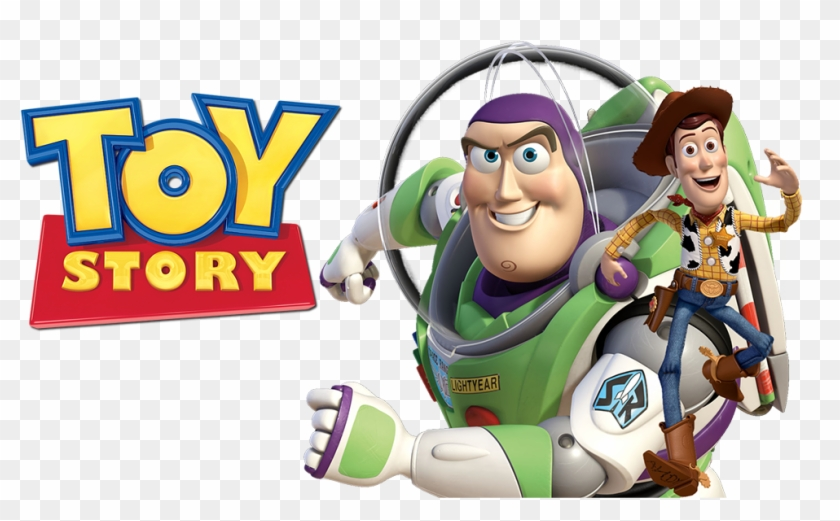